### Connexion to the Thymio

##### Group n. 14. Members : Enrique Bosch Tamayo, Edoardo Finamore, Aubane Lachat, Louis Litzler-Italia

***This is the main code of the project, allowing you to run the entire project and visualize its outcomes. The 'theoretical report' exists in another Jupyter Notebook, completely separate from this one. You can find it under the name 'Final project notebook'***

In [44]:
from tdmclient import ClientAsync
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()
await node.wait_for_variables()
node.var

{'_fwversion': [14, 0],
 '_id': [1],
 '_productId': [8],
 'button.backward': [0],
 'button.center': [0],
 'button.forward': [0],
 'button.left': [0],
 'button.right': [0],
 'buttons._raw': [11230, 9554, 14430, 14356, 15793],
 'event.args': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'event.source': [1],
 '_imot': [0, 0],
 '_vbat': [905, 914],
 'buttons._mean': [11193, 9521, 14405, 14324, 15736],
 'buttons._noise': [79, 67, 85, 99, 88],
 'motor.left.speed': [0],
 'motor.left.target': [0],
 'motor.right.speed': [0],
 'motor.right.target': [0],
 'prox.comm.rx': [0],
 'prox.comm.rx._intensities': [0, 0, 0, 0, 0, 0, 0],
 'prox.comm.rx._payloads': [0, 0, 0, 0, 0, 0, 0],
 'prox.comm.tx': [0],
 'prox.ground.ambiant': [1, 2],
 'prox.ground.delta': [892, 1000],
 'prox.ground.reflected': [815, 933],
 'prox.horizontal': [0, 0, 0, 0, 0, 0, 0],
 '_integrator': [0, 0],
 'acc': [0, 0, 2

### Import section

In [2]:
import numpy as np
import math
import cv2

from Functions.motor import *
from Functions.vision import *
from Functions.Control import *
from Functions.Kalman import *
from Functions.local_navigation import *
from Functions.A import *
from Functions.conversions import *



### Main parameters initialization

In [3]:
############################## MAIN PARAMETERS INITIALIZATION ###################################


# Sample time
Ts = 0.2

# Convertion ratios for speed calculations
conv_ratio_left = 59
conv_ratio_right = 59

# Wheels parameters
R = 20
L = 62

# State covariance matrix P_k_minus_1
P_k_minus_1 = np.array([[0.1,0,0,0,0],
                    [0,0.1,0,0,0],
                    [0,0,0.1,0,0],
                    [0,0,0,0.1,0],
                    [0,0,0,0,0.1]])  


# Treshold for convergence
trsh = 50 #[mm]



# Map size
map_size=(750,1090)

### Creation of the occupancy grid

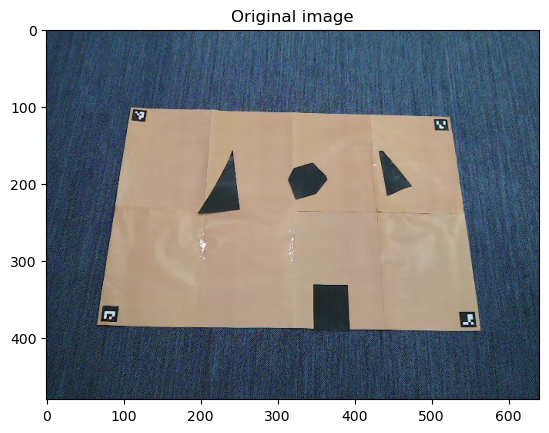

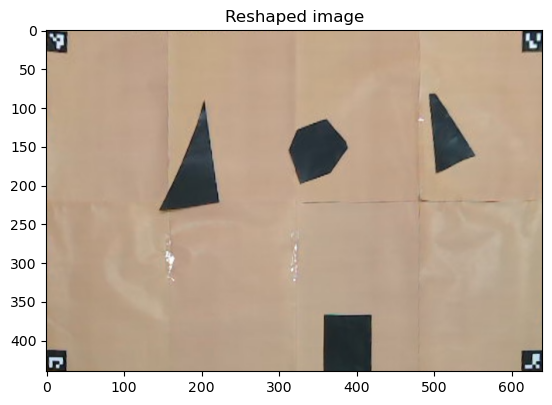

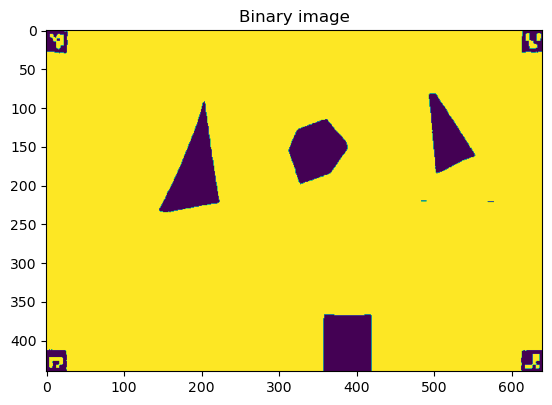

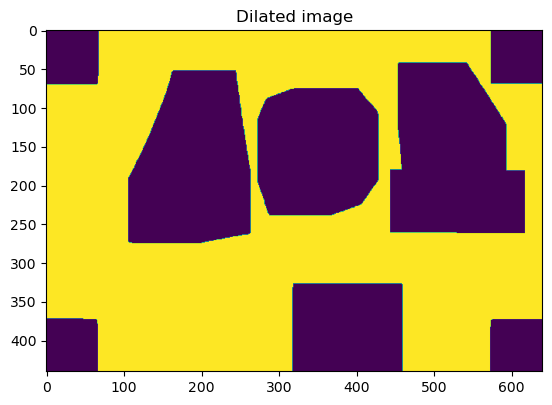

In [47]:
####################### OCCUPANCY GRID ############################

# Params given by vision occupancy_grid  

corner_position, last_frame = detect_map_corners(camera_index=0) # Returns the position of the corners of the map as well as an image of the map

occupancy_grid= img_to_grid(last_frame, map_size, corner_position) # Returns the occupancy grid in the form of a matrix of zeros and ones. 

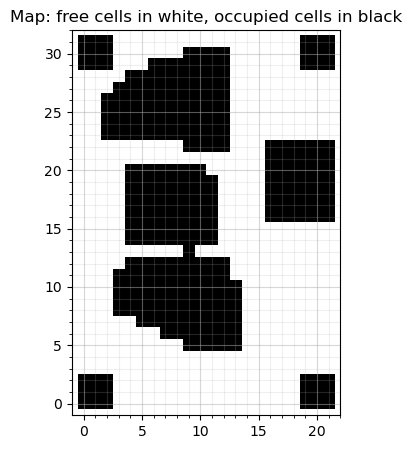

In [48]:
# Display the occupancy grid

display_occupancy_grid(occupancy_grid)

### Initialization of start point and goal point in the different coordinate systems

In [49]:
####################### START AND GOAL ############################

# Capture the initial frame for initial robot and goal poses
frame_robot_goal, cap = capture_frame(camera_index=0) # Returns a frame only if the robot and the goal markers are detected at the same time

# Get the goal position in mm in the image coordinate system
goal_pos_mm = get_goal_pos(frame_robot_goal, map_size, corner_position) 

# Get the initial pose of the robot in mm in the image coordinate system
state_vision_mm = np.array([0, 0, 0])
state_vision_mm = get_robot_pose(frame_robot_goal, map_size, corner_position, state_vision_mm)

# Get the initial pose of the robot in mm in the control coordinate system
state_vision_control  = img_to_map_coordinates(state_vision_mm, map_size[0])
optimal_state_estimate_k = state_vision_control

# Get the initial pose of the robot in grid cells in the grid coordinate system
square_size = grid_to_mm(occupancy_grid, map_size) # Length of a cell of the occupancy grid

state_vision_square = (int(state_vision_mm[0] / square_size), int(state_vision_mm[1] /square_size), state_vision_mm[2])  # Robot pose in grid cells
goal_pos_square = (int(goal_pos_mm[0] / square_size), int(goal_pos_mm[1] /square_size)) # Goal pose in grid cells

state_vision_grid = (state_vision_square[1], state_vision_square[0]) # Robot pose in the grid coordinate system
goal_pos_grid = (goal_pos_square[1], goal_pos_square[0]) # Goal pose in the grid coordinate system

print(goal_pos_grid)
print(state_vision_grid)

(7, 3)
(14, 26)


### Computation of the optimal path using A* algorithm

In [50]:
####################### A* ############################

# Run the A* algorithm to find the optimal path, returned in "gloabal navigation"
global_navigation = A_Star(state_vision_grid, goal_pos_grid, occupancy_grid, movement_type="8N")

# Multiply global navigation by cell size to transform it in mm
global_navigation = np.array(global_navigation) * square_size

# Transform the optimal_path from grid coordinate system to control coordinate system
global_navigation = grid_to_map_coordinates(global_navigation, map_size[0])    

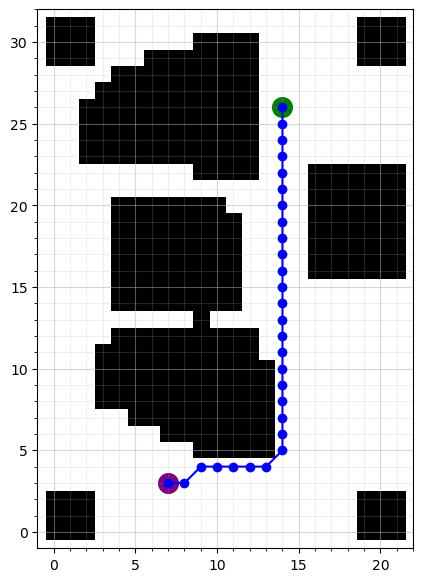

In [51]:
# Display the optimal path

display_optimal_path(state_vision_grid,goal_pos_grid,occupancy_grid)

### Move the robot towards the goal

In [ ]:
while True:
    await node.wait_for_variables()
    await client.sleep(0.02)
    if node.var['acc'][2] > 25:
        print(node.var['acc'][2])

In [52]:
# Initial state estimate
state_estimate_k_minus_1 = np.array([0.0,0.0,0.0, 0.0,0.0])

#Initialize boolean variables
not_converged = 1
not_converged = 1
kidnapped = 0
camera_is_obstructed = 0

# Temporary goal index
k_step_goal = 1 

# Initialize control vector
control_vector_k_minus_1 = [0,0]

k_step_goal = 0 # Temporary goal index

# Plot variables
optimal_states = []
temporary_goals = []   
k_iteration = 0
k_final_kalman = 0
k_initial_kalman = 0
camera_is_obstructed_before = 0

####################### MAIN LOOP ############################
state_vision = state_vision_control

while not_converged:
        
        await node.wait_for_variables()
        await client.sleep(0.02)

        ####################### KIDNAPPING ############################

        if node.var['acc'][2] >25:  # If the robot is lifted up, it is considered as kidnapped

            await node.set_variables(motors(0, 0, verbose=False)) # Stop the robot wheels   
            
            print('Robot kidnapped !')

            ####################### START AND GOAL ############################
            # Capture the initial frame for initial robot and goal poses

            goal_pos_mm = (0, 0)
            state_vision_mm = (0, 0, 0)

            while (goal_pos_mm == (0, 0) or state_vision_mm == (0, 0, 0)): # Break the loop only if the goal and the robot are detected on the same frame
                
                ret, frame = cap.read()

                # get the goal position in mm
                goal_pos_mm = get_goal_pos(frame, map_size, corner_position)

                # Get the initial pose of the robot in mm
                state_vision_mm = np.array([0, 0, 0])
                state_vision_mm = get_robot_pose(frame, map_size, corner_position, state_vision)

            # Get the initial pose of the robot in mm in the control coordinate system
            state_vision_control  = img_to_map_coordinates(state_vision_mm, map_size[0])
            optimal_state_estimate_k = state_vision_control

            # Get the initial pose of the robot in grid cells in the grid coordinate system
            square_size = grid_to_mm(occupancy_grid, map_size) # Length of a square of the occupancy grid

            state_vision_square = (int(state_vision_mm[0] / square_size), int(state_vision_mm[1] /square_size), state_vision_mm[2])  # Robot pose in grid cells
            goal_pos_square = (int(goal_pos_mm[0] / square_size), int(goal_pos_mm[1] /square_size)) # Goal pose in grid cells

            state_vision_grid = (state_vision_square[1], state_vision_square[0]) # Robot pose in the grid coordinate system
            goal_pos_grid = (goal_pos_square[1], goal_pos_square[0]) # Goal pose in the grid coordinate system

            # Save the new start and new goal points for future visualization
            new_start_kidnapp = state_vision_grid
            new_goal_kidnapp = goal_pos_grid

            ####################### A* ############################

            # Run the A* algorithm to find the optimal path, returned in "gloabal navigation"
            global_navigation = A_Star(state_vision_grid, goal_pos_grid, occupancy_grid, movement_type="8N")

            # Multiply global navigation by square size to transform it in mm
            global_navigation = np.array(global_navigation) * square_size

            # Transform the optimal_path from grid coordinate system to control coordinate system
            global_navigation = grid_to_map_coordinates(global_navigation, map_size[0]) 
  
            optimal_states = []
            temporary_goals = []
            not_converged = 1
            kidnapped = 0
            state_vision = state_vision_control

            display_optimal_path(new_start_kidnapp,new_goal_kidnapp,occupancy_grid)

            continue

        #################### CHECK FOR LOCAL OBSTACLE AVOIDANCE ############################
        
        elif await obstacle(node, client) :
                await obstacle_avoidance(node, client)           
            
        else: 

            ####################### VISION ############################

            #updates pose of the robot at each iteration
            ret, frame = cap.read()
            state_vision= get_robot_pose(frame, map_size, corner_position, state_vision)
            
            # transform the state from vision to control coordinates
            state_vision  = img_to_map_coordinates(state_vision, map_size[0])
            
                  
            if state_vision[0]==0:
                state_vision = optimal_state_estimate_k
                camera_is_obstructed = 1
                
            
            ####################### KALMAN FILTER ############################

            # Run the Extended Kalman Filter and store the 
            # near-optimal state and covariance estimates
            
            #check if the camera is obstructed
            camera_is_obstructed = camera_obstructed(frame, threshold=30)
            if camera_is_obstructed:
                 k_initial_kalman = k_iteration

            if not camera_is_obstructed and camera_is_obstructed_before:
                k_final_kalman = k_iteration
            #get measurements from motors
            v,w = convert_to_absolute_speed(node.var['motor.right.target'][0], node.var['motor.left.target'][0], R, L=105, conv_ratio_right=25, conv_ratio_left=25)
            #create the augmenteed observation vector with state_vision and measurements from motors
            obs_vector_z_k = np.array([state_vision[0], state_vision[1], state_vision[2], v, w]) # Most recent sensor measurement
            
            optimal_state_estimate_k_augmented, covariance_estimate_k = ekf1(
                obs_vector_z_k,# Most recent sensor measurement
                state_estimate_k_minus_1, # Our most recent state estimate
                control_vector_k_minus_1, # Our most recent control input
                P_k_minus_1, # Our most recent state covariance matrix
                Ts, # Time interval
                camera_is_obstructed)
            
            # Get ready for the next timestep by updating the variable values
            state_estimate_k_minus_1 = optimal_state_estimate_k_augmented
            P_k_minus_1 = covariance_estimate_k

            optimal_state_estimate_k = optimal_state_estimate_k_augmented[:3]
            
            ####################### APPLY CONTROL ############################
            x_actual = optimal_state_estimate_k[0]
            y_actual = optimal_state_estimate_k[1]
            state_actual = np.array([x_actual, y_actual])
            

            # Calculate the Euclidean distance for each row in the matrix
            global_navigation = np.array(global_navigation)
            distances = np.linalg.norm(global_navigation - state_actual, axis=1)

            #the index of the temporary goal is the one with the minimum distance
            k_step_goal = np.argmin(distances)

            # control if robot is converged
            if k_step_goal == len(global_navigation)-1 and distances[k_step_goal] < trsh:
                not_converged = 0
                await node.set_variables(motors(0, 0, verbose=False))
                break
            else:
                
                x_goal_next = global_navigation[k_step_goal+1][0]
                y_goal_next = global_navigation[k_step_goal+1][1] 

            # If the robot is close enough to the temporary goal, then move to the next temporary goal
            if distances[k_step_goal] < trsh:
                k_step_goal += 1


            # Find the closest temporary goal to the actual robot estimated position
            closest_temporary_goal = global_navigation[k_step_goal]
            x_goal = closest_temporary_goal[0]
            y_goal = closest_temporary_goal[1]
            
               
            # Calculate the control law
            v, w = control_law1(optimal_state_estimate_k, x_goal, y_goal)

            # Convert the control law to motor speed
            v_r, v_l = convert_to_motor_speed(v, w, R, L, conv_ratio_right, conv_ratio_left)
            v_r = int(v_r)
            v_l = int(v_l)
            await node.set_variables(motors(v_l, v_r, verbose=False))
            
            # Memorize the control vector for the next iteration
            v,w = convert_to_absolute_speed(v_r, v_l, R, L=105, conv_ratio_right=25, conv_ratio_left=25)
            control_vector_k_minus_1 = np.array([v, w])
            

            #memorize all the optimal states
            optimal_states.append(optimal_state_estimate_k)
            
            # memorize the temporary goal
            temporary_goals.append(closest_temporary_goal)

            k_iteration += 1
            camera_is_obstructed_before = camera_is_obstructed
            
            await client.sleep(Ts) 



In [18]:
await node.set_variables(motors(0, 0, verbose=False)) # Stop the robot wheels

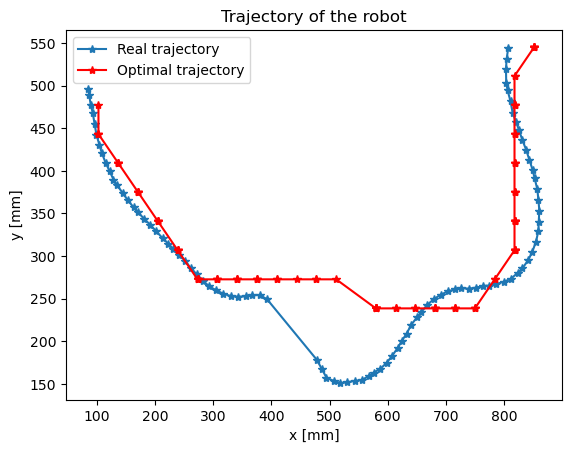

In [46]:
#plot the estimated trajectory and the optimal trajectory in the same plot
plt.plot(np.array(optimal_states)[:,0], np.array(optimal_states)[:,1], marker='*', linestyle='-', label=f'Real trajectory')
plt.plot(np.array(temporary_goals)[:,0], np.array(temporary_goals)[:,1], 'r', marker='*', linestyle='-', label=f'Optimal trajectory')
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
plt.title('Trajectory of the robot')
plt.legend()
plt.show()

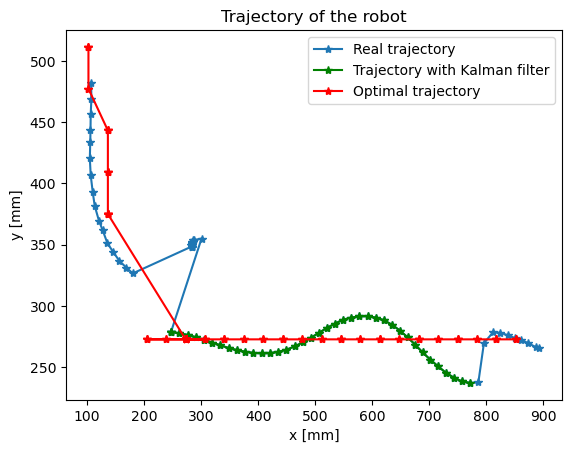

Exception in thread Exception in thread Thread-9:
Traceback (most recent call last):
  File "d:\Programmi\anaconda3\envs\Robotica\lib\threading.py", line 932, in _bootstrap_inner
Exception in thread Thread-7:
Traceback (most recent call last):
  File "d:\Programmi\anaconda3\envs\Robotica\lib\threading.py", line 932, in _bootstrap_inner
Exception in thread Thread-8:
Traceback (most recent call last):
  File "d:\Programmi\anaconda3\envs\Robotica\lib\threading.py", line 932, in _bootstrap_inner
Thread-5:
Traceback (most recent call last):
  File "d:\Programmi\anaconda3\envs\Robotica\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "d:\Programmi\anaconda3\envs\Robotica\lib\site-packages\tdmclient\tcp.py", line 73, in run
    self.run()
  File "d:\Programmi\anaconda3\envs\Robotica\lib\site-packages\tdmclient\tcp.py", line 73, in run
    self.run()
  File "d:\Programmi\anaconda3\envs\Robotica\lib\site-packages\tdmclient\tcp.py", line 73, in run
    self.run()
  File "d:

In [ ]:
# Plot the estimated trajectory and the temporary goals in the same plot
plt.plot(np.array(optimal_states)[:, 0], np.array(optimal_states)[:, 1], marker='*', linestyle='-', label='Real trajectory')
if k_final_kalman == 0:
    k_final_kalman = len(optimal_states)
# k_final_kalman is the minimum index between k_final_kalman and the length of the optimal_states array
k_final_kalman = min(k_final_kalman, len(optimal_states))
if k_initial_kalman == 0:
    k_initial_kalman = len(optimal_states)

k_initial_kalman = 10
# Create a mask for the points in the specified range
mask = (k_initial_kalman <= np.arange(len(optimal_states))) & (np.arange(len(optimal_states)) <= k_final_kalman)

# Plot the points in the specified range with a different color (e.g., green)
plt.plot(np.array(optimal_states)[mask, 0], np.array(optimal_states)[mask, 1], marker='*', linestyle='-', color='green', label='Trajectory with Kalman filter')

# Plot the real trajectory
plt.plot(np.array(temporary_goals)[:, 0], np.array(temporary_goals)[:, 1], 'r', marker='*', linestyle='-', label='Optimal trajectory')

# Set labels and title
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
plt.title('Trajectory of the robot')

# Add legend
plt.legend()

# Show the plot
plt.show()
